## 🛠️ Step 1: Problem Framing & Dataset Setup
Let’s start by framing the problem and loading some synthetic (or placeholder) data to explore. 

---
## ✅ Objective:
We want to recommend optimal prices for products in order to maximize revenue — while considering factors like:

- Price elasticity (how demand changes with price)

- Seasonality (day of week, month)

- Competition (if data available)

- Product type/category

In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)

n_samples = 1000
data = pd.DataFrame({
    'product_id': np.random.choice(['A', 'B', 'C', 'D'], size=n_samples),
    'base_price': np.random.uniform(10, 100, size=n_samples),
    'discount': np.random.uniform(0, 0.3, size=n_samples),
    'day_of_week': np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], size=n_samples),
    'units_sold': None
})

#non-linear relationship between price and units_sold with noise
price_effect = lambda row: max(
    0,
    100 - row['base_price'] * (1 - row['discount']) + np.random.normal(0, 5)
)
data['units_sold'] = data.apply(price_effect, axis=1).astype(int)

#final price and revenue
data['final_price'] = data['base_price'] * (1 - data['discount'])
data['revenue'] = data['final_price'] * data['units_sold']

data.head()

,product_id,base_price,discount,day_of_week,units_sold,final_price,revenue
0,C,72.834554,0.155725,Wed,42,61.492427,2582.681939
1,D,58.248673,0.143755,Sun,58,49.875160,2892.759305
2,A,37.857485,0.007693,Sun,54,37.566262,2028.578160
3,C,83.241552,0.102374,Sun,26,74.719752,1942.713556
4,C,71.625806,0.114059,Thu,35,63.456260,2220.969110


## 📊 Step 2: Exploratory Data Analysis (EDA)
### Before we jump into modeling, we must understand our data:

- Are the relationships logical?

- Do we have any outliers or imbalances?

- What patterns jump out?

### We'll look at:

- Overall data shape + types

- Distribution of final prices and units sold

- Revenue patterns by product and weekday

- Correlation between price and units sold

In [2]:
#General info
print('Dataset Shape:', data.shape)
print('\nColumn data types:', data.dtypes)
print('\nMissing Values:', data.isnull().sum())

Dataset Shape: (1000, 7)

Column data types: product_id      object
base_price     float64
discount       float64
day_of_week     object
units_sold       int32
final_price    float64
revenue        float64
dtype: object

Missing Values: product_id     0
base_price     0
discount       0
day_of_week    0
units_sold     0
final_price    0
revenue        0
dtype: int64


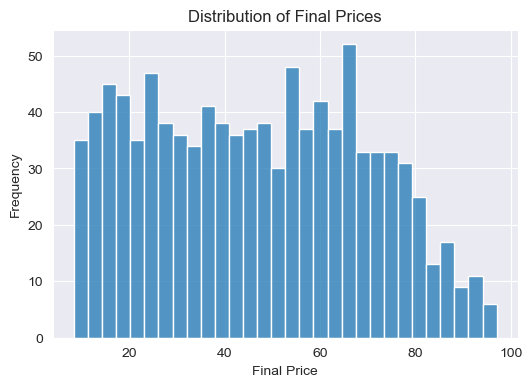

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

#hist - final price distribution
plt.figure(figsize=(6, 4))
sns.histplot(data['final_price'], bins=30)
plt.title('Distribution of Final Prices')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

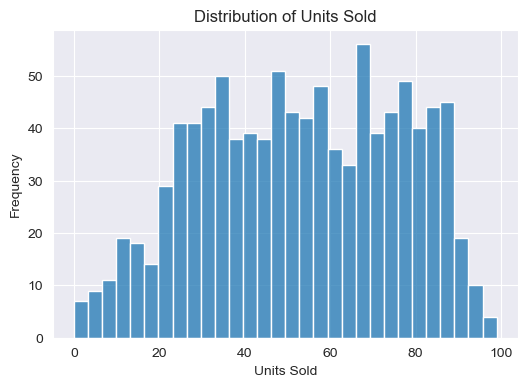

In [4]:
#hist - units sold dist
plt.figure(figsize=(6, 4))
sns.histplot(data['units_sold'], bins=30)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

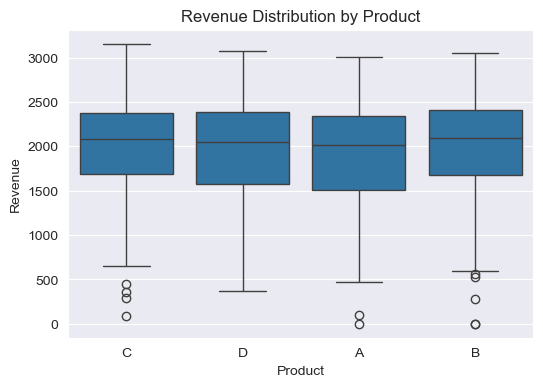

In [5]:
#box - revenue by product
plt.figure(figsize=(6, 4))
sns.boxplot(x='product_id', y='revenue', data=data)
plt.title('Revenue Distribution by Product')
plt.xlabel('Product')
plt.ylabel('Revenue')
plt.show()

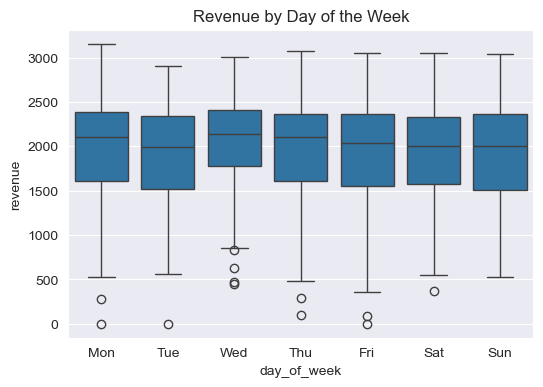

In [6]:
#box - revenue by day of the week
plt.figure(figsize=(6, 4))
sns.boxplot(x='day_of_week', y='revenue', data=data, order=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Revenue by Day of the Week')
plt.show()

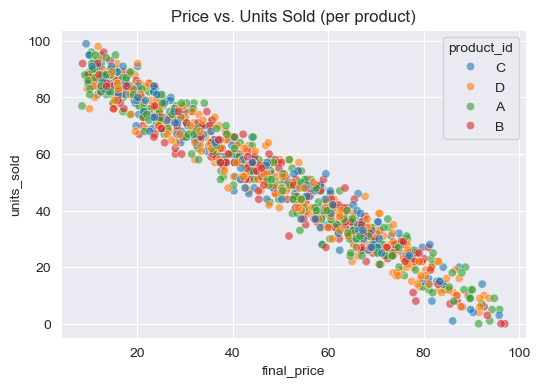

In [7]:
#scatter - final price vs units sold
plt.figure(figsize=(6, 4))
sns.scatterplot(x='final_price', y='units_sold', data=data, hue='product_id', alpha=0.6)
plt.title('Price vs. Units Sold (per product)')
plt.show()

## 🧪 Step 3: Feature Engineering for Price Elasticity Modeling
Now we’ll prep features that help us predict units_sold from price and context. This is essentially modeling demand. Later, we’ll use this to simulate revenue at different prices — and optimize it.

---
## 🎯 What We're Doing:
- Keep: final_price, product_id, day_of_week

- Encode: product_id and day_of_week (categorical → numerical)

- Drop: revenue and units_sold (it’s the target)

In [8]:
#one hot encoding for product & weekday
data_fe = pd.get_dummies(data, columns=['product_id', 'day_of_week'], drop_first=True)

#X & y
features = data_fe.drop(columns=['units_sold', 'revenue'])
target = data_fe['units_sold']

print('Feature Shape:', features.shape)
features.head()

Feature Shape: (1000, 12)


,base_price,discount,final_price,product_id_B,product_id_C,product_id_D,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed
0,72.834554,0.155725,61.492427,False,True,False,False,False,False,False,False,True
1,58.248673,0.143755,49.875160,False,False,True,False,False,True,False,False,False
2,37.857485,0.007693,37.566262,False,False,False,False,False,True,False,False,False
3,83.241552,0.102374,74.719752,False,True,False,False,False,True,False,False,False
4,71.625806,0.114059,63.456260,False,True,False,False,False,False,True,False,False


## 🔍 Why We're Doing This:
- We want a model to understand how different features affect units sold

- One-hot encoding helps the model treat products and days as non-ordinal categories

- Dropping one category per variable (drop_first=True) avoids multicollinearity

## 🤖 Step 4: Train a Regression Model to Predict Demand
### We’ll start simple with Linear Regression to:

- Get interpretable coefficients

- Understand the price sensitivity (elasticity)

- See how other features (product, day) influence demand

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#fit lr
lr = LinearRegression()
lr.fit(X_train, y_train)

#predict
y_pred = lr.predict(X_test)

#metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📉 Mean Squared Error: {mse:.2f}")
print(f"📈 R^2 Score: {r2:.2f}")

📉 Mean Squared Error: 26.21
📈 R^2 Score: 0.95


## 🔍 What’s Happening:
- We split the data: 80% train / 20% test

- We fit a linear regression: predicts units sold from price and other features

### We measure:

- MSE (lower is better)

- R² score (explained variance; closer to 1 = good)

## 🧠 Step 5: Interpret the Model (Coefficients = Elasticity)
### We’ll:

- Create a tidy dataframe of feature names + their learned weights

- Sort to see the most impactful features

- Discuss how to interpret the price coefficient

In [10]:
#create a df of coefs
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_
}).sort_values(by='coefficient', ascending=False)

print("🔝 Top Positive Effects:")
display(coef_df.head())

print("\n🔻 Most Negative Effects:")
display(coef_df.tail())

🔝 Top Positive Effects:


,feature,coefficient
6,day_of_week_Mon,0.809644
8,day_of_week_Sun,0.727961
10,day_of_week_Tue,0.687128
9,day_of_week_Thu,0.681201
11,day_of_week_Wed,0.608885



🔻 Most Negative Effects:


,feature,coefficient
5,product_id_D,0.289756
0,base_price,0.028088
3,product_id_B,-0.354037
2,final_price,-1.038468
1,discount,-5.550478


## 📘 How to Read This:
- Positive coefficient → increases units sold (e.g., specific product or day)

- Negative coefficient → reduces units sold (e.g., higher final price)

- final_price should have a strong negative coefficient, confirming price elasticity


## 📈 Step 6: Simulate Revenue at Different Prices
Now that we’ve trained a model to predict units sold based on price and other features, we can:

1. Choose a product (e.g. "A")

2. Simulate many price points (e.g. $10 to $100)

3. Predict units sold at each price

4. Calculate revenue = price × predicted units

5. Plot revenue vs price → to find the perfect price spot

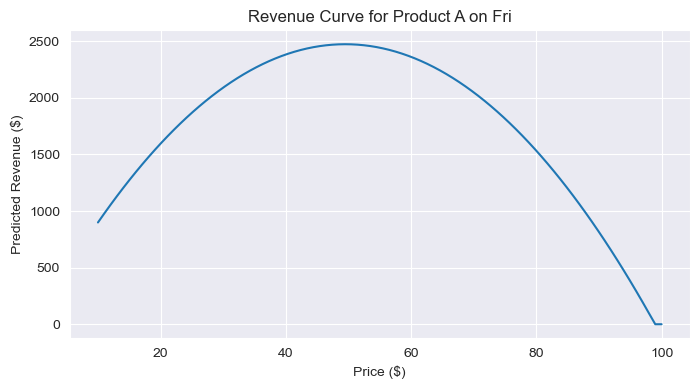

🏆 Optimal price: $49.44 — expected revenue: $2473.63


In [14]:
# choose product to simulate
product_to_test = 'A'
day ='Fri'

#test prices
price_range = np.linspace(10, 100, 90)

#create df for simulation
sim_data = pd.DataFrame({
    'base_price': price_range,
    'discount': 0.0 #rn no discount so final price = base price
})
sim_data['final_price'] = sim_data['base_price']

#product & day columns (one-hot)
for p in ['B', 'C', 'D']:
    sim_data[f'product_id_{p}'] = 1 if p == product_to_test else 0
    
for d in ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
    sim_data[f'day_of_week_{d}'] = 1 if p == product_to_test else 0
    
missing_cols = set(X_train.columns) - set(sim_data.columns)
for col in missing_cols:
    sim_data[col] = 0
    
sim_data = sim_data[X_train.columns]

sim_data['predicted_units'] = lr.predict(sim_data)
sim_data['predicted_units'] = sim_data['predicted_units'].clip(lower=0)
sim_data['revenue'] = sim_data['final_price'] * sim_data['predicted_units']

#plot revenue vs price
plt.figure(figsize=(8, 4))
plt.plot(sim_data['final_price'], sim_data['revenue'])
plt.xlabel('Price ($)')
plt.ylabel('Predicted Revenue ($)')
plt.title(f'Revenue Curve for Product {product_to_test} on {day}')
plt.grid(True)
plt.show()

best_row = sim_data.loc[sim_data['revenue'].idxmax()]
print(f"🏆 Optimal price: ${best_row['final_price']:.2f} — expected revenue: ${best_row['revenue']:.2f}")

## 🧱 Step 7: Build a Reusable Price Optimization Function
To make this project modular and production-ready, let’s wrap our logic into a function:

Input:

- Model

- Product ID

- Day of week

- (Optional) discount or price range

Output:

- DataFrame of predicted revenue

- Optimal price and revenue

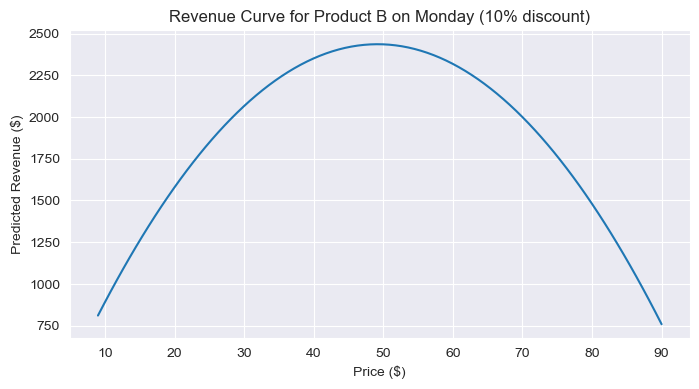

🏆 Optimal price: $49.04 — expected revenue: $2436.36


In [16]:
def simulate_price_curve(
        model, 
        X_template,
        product_id='A',
        day='Fri',
        discount=0.0,
        price_range=np.linspace(10, 100, 90)
):
    sim_data = pd.DataFrame({
        'base_price': price_range,
        'discount': discount
    })
    sim_data['final_price'] = sim_data['base_price'] * (1 - discount)
    
    for p in ['B', 'C', 'D']:
        sim_data[f'product_id_{p}'] = 1 if p == product_id else 0
    for d in ['Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']:
        sim_data[f'day_of_week_{d}'] = 1 if d == day else 0
        
    #fill missing columns w/ 0
    missing_cols = set(X_template.columns) - set(sim_data.columns)
    for col in missing_cols:
        sim_data[col] = 0
        
    #align columns
    sim_data = sim_data[X_template.columns]
    
    #Predict units and revenue
    sim_data['predicted_units'] = np.clip(model.predict(sim_data), a_min=0, a_max=None)
    sim_data['revenue'] = sim_data['final_price'] * sim_data['predicted_units']
    
    return sim_data

sim_result = simulate_price_curve(lr, X_train, product_id='B', day='Mon', discount=0.1)

plt.figure(figsize=(8, 4))
plt.plot(sim_result['final_price'], sim_result['revenue'])
plt.xlabel('Price ($)')
plt.ylabel('Predicted Revenue ($)')
plt.title(f'Revenue Curve for Product B on Monday (10% discount)')
plt.grid(True)
plt.show()

best_row = sim_result.loc[sim_result['revenue'].idxmax()]
print(f"🏆 Optimal price: ${best_row['final_price']:.2f} — expected revenue: ${best_row['revenue']:.2f}")

## 🧮 Step 8: Batch Optimization for All Products & Days
Now let’s do this for all combinations of:

- product_id: A, B, C, D

- day_of_week: Mon–Sun

This simulates a pricing assistant that recommends the best price for every product-day combo.

In [19]:
results = []

product_ids = ['A', 'B', 'C', 'D']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for product in product_ids:
    for day in days:
        sim = simulate_price_curve(
            model=lr, 
            X_template=X_train, 
            product_id=product, 
            day=day, 
            discount=0.0
        )
        best_row = sim.loc[sim['revenue'].idxmax()]
        results.append({
            'product_id': product,
            'day_of_week': day,
            'optimal_price': best_row['final_price'],
            'expected_revenue': best_row['revenue'],
        })
        
opt_df = pd.DataFrame(results)
opt_df = opt_df.sort_values(['product_id', 'day_of_week'])

opt_df.head()

,product_id,day_of_week,optimal_price,expected_revenue
4,A,Fri,49.438202,2473.629708
0,A,Mon,49.438202,2473.629708
5,A,Sat,49.438202,2502.964138
6,A,Sun,49.438202,2509.618799
3,A,Thu,49.438202,2507.307046


## 📊 Step 9: Visualize Optimal Prices and Expected Revenues
We'll make:

- A heatmap showing optimal price per product and day

- A barplot showing expected revenue across product-day combos

This helps stakeholders understand when and for which product higher or lower pricing works best.



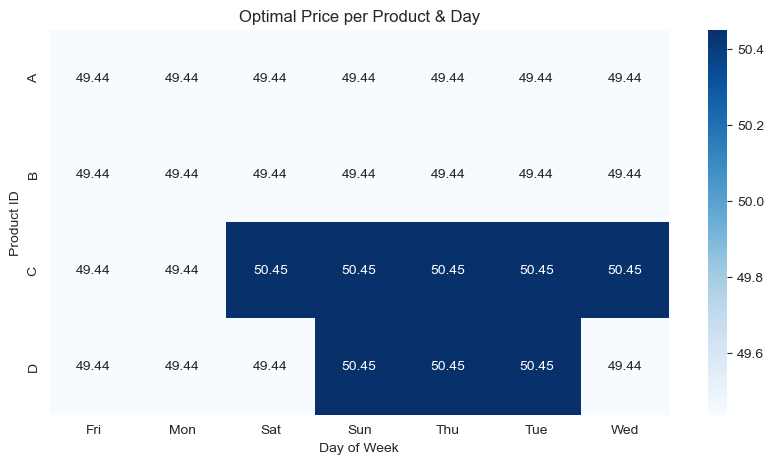

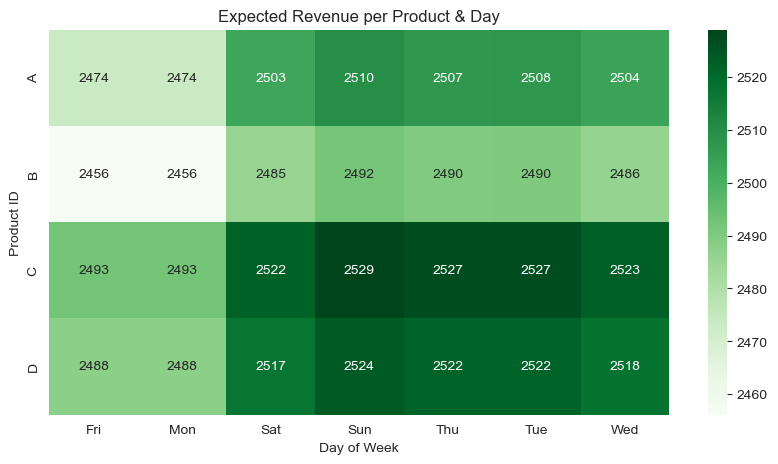

In [21]:
#heatmaps
pivot_price = opt_df.pivot(index='product_id', columns='day_of_week', values='optimal_price')
pivot_revenue = opt_df.pivot(index='product_id', columns='day_of_week', values='expected_revenue')

#optimal price
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_price, annot=True, fmt='.2f', cmap="Blues")
plt.title('Optimal Price per Product & Day')
plt.ylabel('Product ID')
plt.xlabel('Day of Week')
plt.show()

#expected revenue
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_revenue, annot=True, fmt=".0f", cmap="Greens")
plt.title('Expected Revenue per Product & Day')
plt.ylabel('Product ID')
plt.xlabel('Day of Week')
plt.show()

## Save the Output

In [22]:
opt_df.to_csv('optimal_price.csv', index=False)
print("✅ optimal_prices.csv saved.")

✅ optimal_prices.csv saved.
